# Elastic Net Logistic Regression 

### As the first step, I will import and load all the dependencies. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import scipy.stats as stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve, confusion_matrix

### In the following cell, the feature extractor all of us used is shown 

In [3]:

def extractor(df, threshold=0.9):
    """
    ************************************************************************
    EXPLANATIONS
    
    Filter features based on correlation threshold and visualize the correlation matrices.
    
    In practice a threshold of 0.9 is widespread but there exists more conservatve
    thresholds like 0.8 which is a more conservative approach. You may choose it
    depending on the context.
    
    ************************************************************************
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the features.
    threshold (float): The correlation threshold to filter features. Default is 0.9.
    
    Returns:
    selected_features (list): List of features with correlation below the threshold.
    excluded_features (list): List of features with correlation above the threshold.
    """
    
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    
    # Create lists for selected features ("normal correlations") and excluded features (perfectly/almost perfectly correlated)
    selected_features = []
    excluded_features = []

    # Run through the upper triangular matrix of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                excluded_features.append(colname)

    # fill lists of excluded and selected features
    excluded_features = list(set(excluded_features))
    selected_features = [feature for feature in corr_matrix.columns if feature not in excluded_features]

    # create correlation matrix of selected features
    selected_corr_matrix = corr_matrix.loc[selected_features, selected_features]

    # plot correlation matrix of selected features
    plt.figure(figsize=(12, 10))
    sns.heatmap(selected_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Selected Features')
    plt.show()

    # create correlation matrix of excluded features and plot it
    if excluded_features:
        remaining_corr_matrix = corr_matrix.loc[excluded_features, excluded_features]        
        plt.figure(figsize=(20, 16))
        sns.heatmap(remaining_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Correlation Matrix of Excluded Features')
        plt.show()
    else:
        print("No excluded features found.")

    # print lists of selected/excluded features
    print("Selected Features:", selected_features)
    print("Excluded Features:", excluded_features)


    # return lists of selected and excluded features
    return selected_features, excluded_features

### For the next step I am removing the columns that are not needed, before calling the introduced extractor method. 

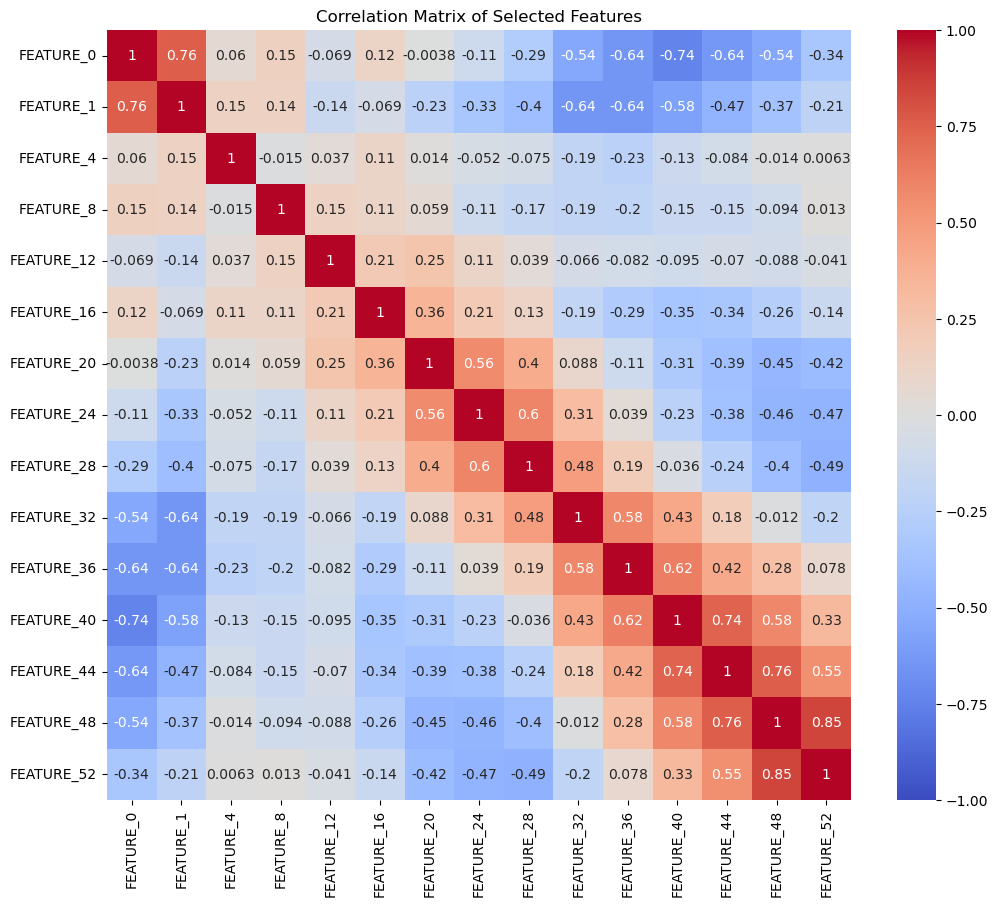

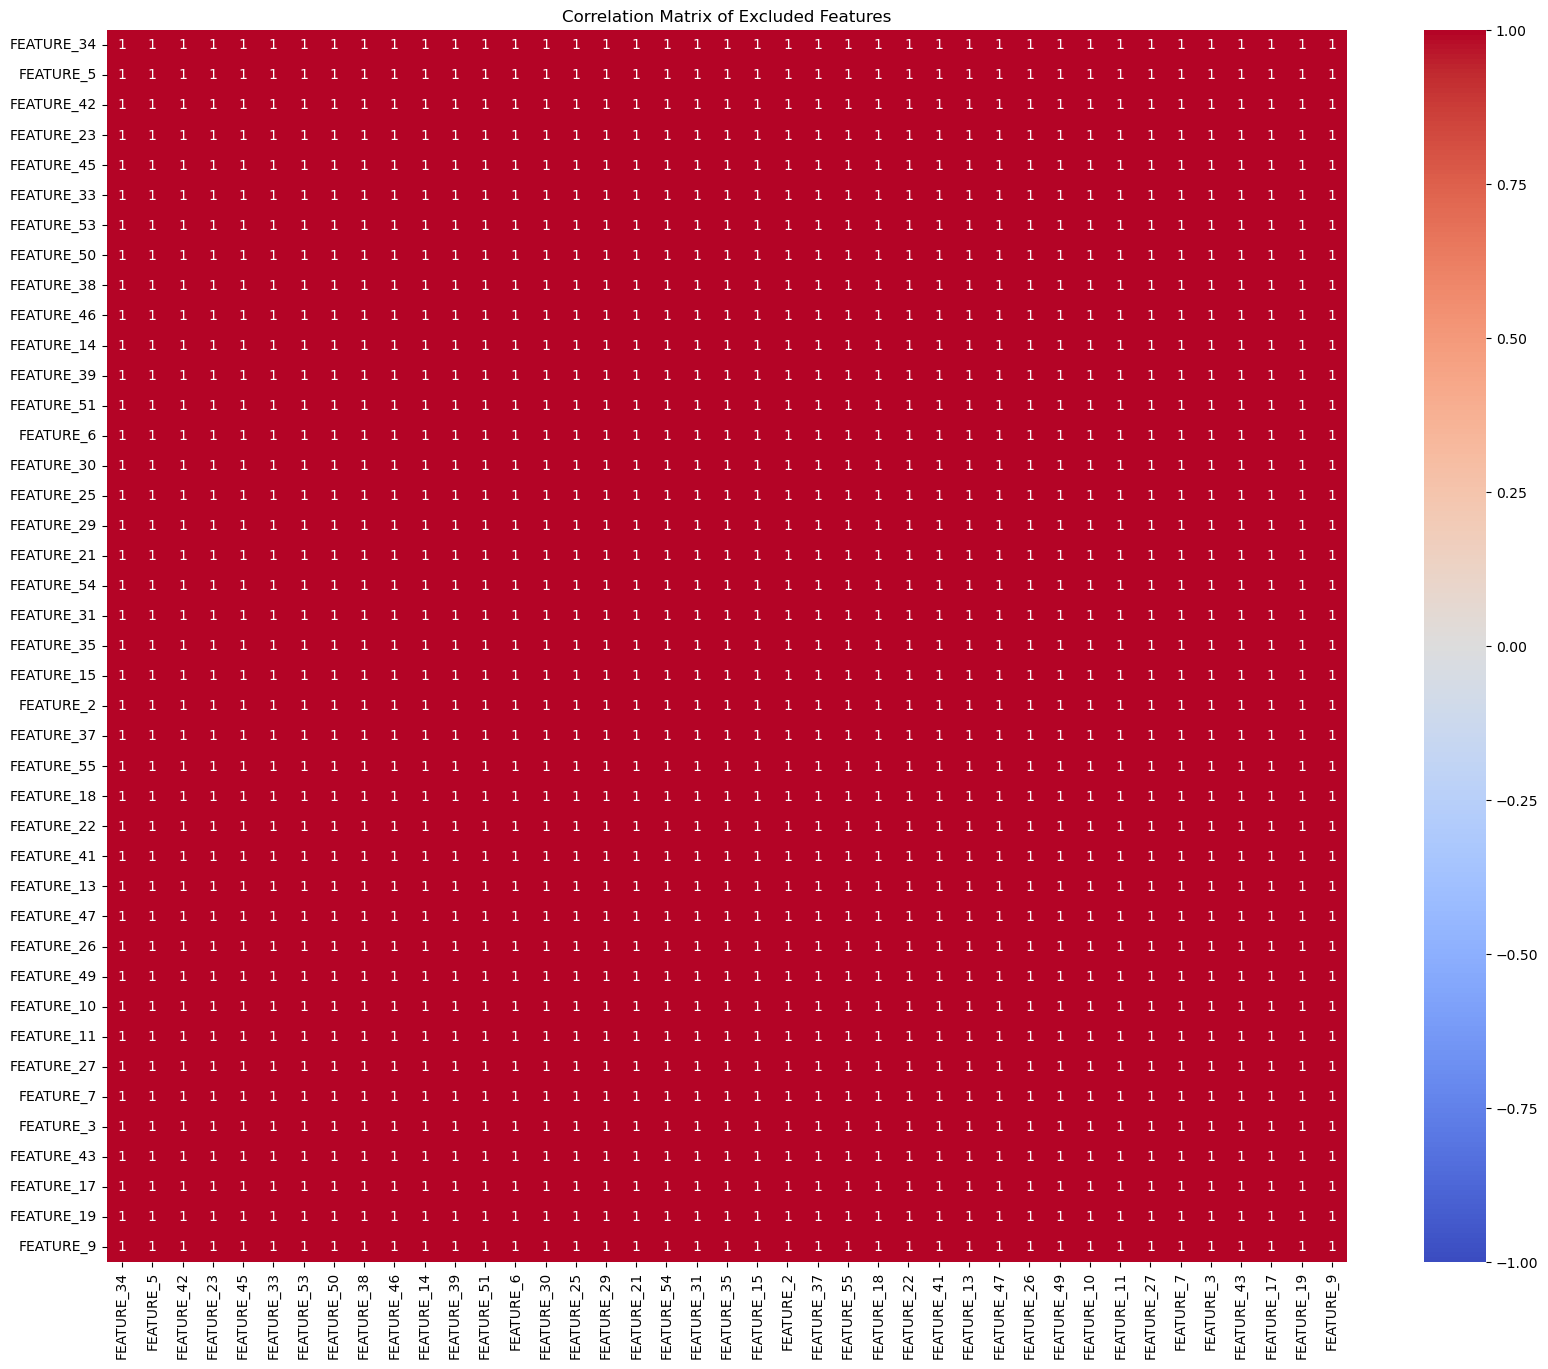

Selected Features: ['FEATURE_0', 'FEATURE_1', 'FEATURE_4', 'FEATURE_8', 'FEATURE_12', 'FEATURE_16', 'FEATURE_20', 'FEATURE_24', 'FEATURE_28', 'FEATURE_32', 'FEATURE_36', 'FEATURE_40', 'FEATURE_44', 'FEATURE_48', 'FEATURE_52']
Excluded Features: ['FEATURE_34', 'FEATURE_5', 'FEATURE_42', 'FEATURE_23', 'FEATURE_45', 'FEATURE_33', 'FEATURE_53', 'FEATURE_50', 'FEATURE_38', 'FEATURE_46', 'FEATURE_14', 'FEATURE_39', 'FEATURE_51', 'FEATURE_6', 'FEATURE_30', 'FEATURE_25', 'FEATURE_29', 'FEATURE_21', 'FEATURE_54', 'FEATURE_31', 'FEATURE_35', 'FEATURE_15', 'FEATURE_2', 'FEATURE_37', 'FEATURE_55', 'FEATURE_18', 'FEATURE_22', 'FEATURE_41', 'FEATURE_13', 'FEATURE_47', 'FEATURE_26', 'FEATURE_49', 'FEATURE_10', 'FEATURE_11', 'FEATURE_27', 'FEATURE_7', 'FEATURE_3', 'FEATURE_43', 'FEATURE_17', 'FEATURE_19', 'FEATURE_9']


(['FEATURE_0',
  'FEATURE_1',
  'FEATURE_4',
  'FEATURE_8',
  'FEATURE_12',
  'FEATURE_16',
  'FEATURE_20',
  'FEATURE_24',
  'FEATURE_28',
  'FEATURE_32',
  'FEATURE_36',
  'FEATURE_40',
  'FEATURE_44',
  'FEATURE_48',
  'FEATURE_52'],
 ['FEATURE_34',
  'FEATURE_5',
  'FEATURE_42',
  'FEATURE_23',
  'FEATURE_45',
  'FEATURE_33',
  'FEATURE_53',
  'FEATURE_50',
  'FEATURE_38',
  'FEATURE_46',
  'FEATURE_14',
  'FEATURE_39',
  'FEATURE_51',
  'FEATURE_6',
  'FEATURE_30',
  'FEATURE_25',
  'FEATURE_29',
  'FEATURE_21',
  'FEATURE_54',
  'FEATURE_31',
  'FEATURE_35',
  'FEATURE_15',
  'FEATURE_2',
  'FEATURE_37',
  'FEATURE_55',
  'FEATURE_18',
  'FEATURE_22',
  'FEATURE_41',
  'FEATURE_13',
  'FEATURE_47',
  'FEATURE_26',
  'FEATURE_49',
  'FEATURE_10',
  'FEATURE_11',
  'FEATURE_27',
  'FEATURE_7',
  'FEATURE_3',
  'FEATURE_43',
  'FEATURE_17',
  'FEATURE_19',
  'FEATURE_9'])

In [4]:
# Load the different datasets; always activate only one and change title results accordingly

#data = pd.read_csv('/home/jovyan/Depression_Level_Classifier/data/Threshold_6_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100.csv')
data = pd.read_csv('/home/jovyan/Depression_Level_Classifier/data/Threshold_19_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100.csv')

#keep track which threshold and version to save results correctly. 
#title_results = "TH6_BP_PHQ_9"
title_results = "TH19_MH_PHQ_S"

columns_with_features = [col for col in data.columns if "FEATURE" in col]

extractor(data[columns_with_features])

### These chosen features are the same for both of my datasets, so I will only visualize them once. 
### For the Data, I will only include the selected features from above, and the target variable will be the binary value indicating the Depression.


In [5]:
# Define Data and Target for the training process

X = data[['FEATURE_0', 'FEATURE_1', 'FEATURE_4', 'FEATURE_8', 'FEATURE_12', 'FEATURE_16', 'FEATURE_20', 'FEATURE_24', 'FEATURE_28', 'FEATURE_32', 'FEATURE_36', 'FEATURE_40', 'FEATURE_44', 'FEATURE_48', 'FEATURE_52']]
y = data['Depression']
print(X.head)
print(X.shape)

<bound method NDFrame.head of       FEATURE_0  FEATURE_1  FEATURE_4  FEATURE_8  FEATURE_12  FEATURE_16  \
0      4.747527  -0.461150  -0.448589  -0.221146    0.632626    0.503027   
1      4.142727  -0.406044  -0.354662  -0.385285    0.005761    1.365143   
2      5.211727  -0.409691  -0.361261  -0.373108   -0.352497    1.025666   
3      5.243849  -0.421691  -0.413585  -0.271198   -0.135320    0.954109   
4      6.457809  -0.345689  -0.225676   0.264825   -0.121930    0.727784   
...         ...        ...        ...        ...         ...         ...   
1115   3.952902  -0.422550  -0.413770  -0.338969    0.286243    1.665862   
1116   5.058712  -0.445300  -0.198749  -0.412035   -0.200104    0.944554   
1117   4.656462  -0.412096  -0.354861  -0.324757   -0.144767    0.250455   
1118   6.402835  -0.361157  -0.339015  -0.239876    0.037329    1.565932   
1119   6.402835  -0.361157  -0.339015  -0.239876    0.037329    1.565932   

      FEATURE_20  FEATURE_24  FEATURE_28  FEATURE_32  FEA

### Next the data will be split and standardized

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1896)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### To find well performing parameters for my model, I perform a grid search, in this case mainly to find suitable values for C and the l1 Ratio. 
### The best found parameters are then used to train the Elastic Net Logistic Regression

In [7]:
# Define the grid for grid search
param_grid = {
    'C': [ 0.1, 1, 10, 50, 100, 500, 1000, 5000], 
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'class_weight': ['balanced'],
    'max_iter': [10000],
}

# GridSearchCV for the Elastic Net
grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, scoring='roc_auc', cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# include the best parameters from the gridsearch
best_params_grid = grid_search.best_params_
print(f'Best parameters from grid search: {best_params_grid}')

# final model with the best parameters
logistic_en = LogisticRegression(**best_params_grid)
logistic_en.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters from grid search: {'C': 1000, 'class_weight': 'balanced', 'l1_ratio': 0.7, 'max_iter': 10000, 'penalty': 'elasticnet', 'solver': 'saga'}


LogisticRegression(C=1000, class_weight='balanced', l1_ratio=0.7,
                   max_iter=10000, penalty='elasticnet', solver='saga')

### The last step is to visualize the results of the machine. For that I have the option to implement a treshold for the prediction of the machine to get the binary prediction. To evaluate the results we used the metrics proposed in the task description. 

Threshold = 0.5
Accuracy: 0.6161, Precision: 0.4623, Recall: 0.6282, F1-score: 0.5326, ROC AUC: 0.6482
Confusion Matrix:
[[89 57]
 [29 49]]



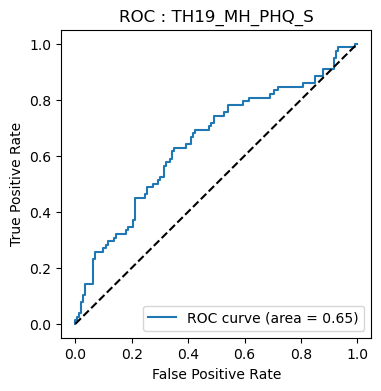

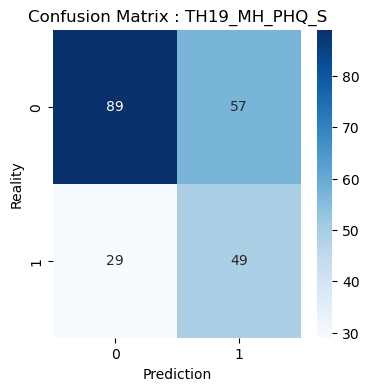

In [9]:
# Comparing different tresholds
thresholds = [ 0.5]

# Evaluate the model for each threshold
for threshold in thresholds:
    # Predict probabilities and convert to binary predictions
    y_pred_prob = logistic_en.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Print results for each threshold
    print(f"Threshold = {threshold}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()

    # ROC
    plt.figure(figsize=(4, 4))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_prob):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC : {title_results}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    #plt.savefig(f'ROC/ROC_Elastic_Net_Classifier_{title_results}.png')
    plt.show()
    
    # confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix : {title_results}')
    plt.xlabel('Prediction')
    plt.ylabel('Reality')
    #plt.savefig(f'Confusion_Matrix/Conf_Elastic_Net_Classifier_{title_results}.png') 
    plt.show()


### Both ROC Curves and Confusion Matrices for each dataset are stored as png files in their respective folders inside this /Ben folder.

### This machine performs well to achieve scores over 0.8 in every metric when using the BP_PHQ_9 dataset. Additionaly the ROC AUC score achieves a value of 0.85.
### However when trained on the MH_PHQ_S dataset, the machine is not able to produce the results again. The ROC AUC is now only at 0.65. 

### Other used Metrics:
### BP_PHQ_9 Data(TH0.6) : Accuracy: 0.8281, Precision: 0.8305, Recall: 0.8033, F1-score: 0.8167, ROC AUC: 0.8466
### MH_PHQ_S Data(TH0.5) : Accuracy: 0.6696, Precision: 0.5435, Recall: 0.3205, F1-score: 0.4032, ROC AUC: 0.6482